<a href="https://colab.research.google.com/github/FarizKesten/CppPackagingExamples/blob/main/TestSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# useful segmentation model libraries
!pip install -q segmentation-models-pytorch

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp


import matplotlib.pyplot as plt
from tqdm import tqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

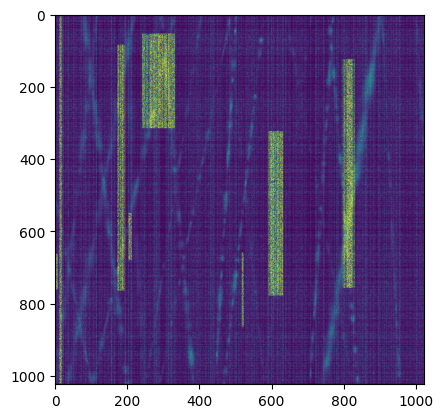

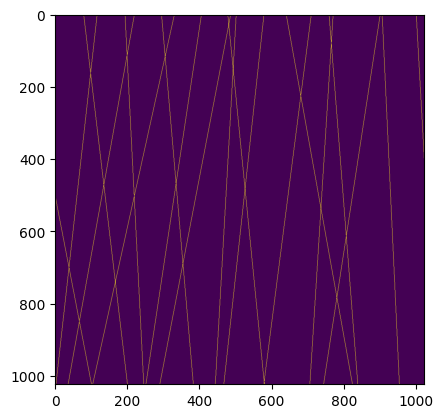

In [2]:
# try reading 1 image

import matplotlib.pyplot as plt

image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)

image_size = int(np.sqrt(len(image)))

image_reshaped = image.reshape((image_size, image_size))
labelimg_reshaped = label.reshape((image_size, image_size))

plt.imshow(image_reshaped)
plt.show()

plt.imshow(labelimg_reshaped)
plt.show()


In [3]:
# TEST: get min max and statistic of labelimg_reshaped

print(np.min(labelimg_reshaped))
print(np.max(labelimg_reshaped))
print(np.median(labelimg_reshaped))
print(np.mean(labelimg_reshaped))
print(np.std(labelimg_reshaped))

0.0
1.0
0.0
0.01745987
0.13097715


In [32]:
# Create a model for the segmentation

# (1): use UNet

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)



# Load & Transform Dataset


In [33]:
from sklearn.model_selection import train_test_split

file_names = os.listdir('/content/drive/MyDrive/ml_data/unet/cnn1/data/img')
train_files, rest_files = train_test_split(file_names, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(rest_files, test_size=0.5, random_state=42)

print(len(train_files))
print(len(val_files))
print(len(test_files))

140
30
30


In [34]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random



class SegmentationDataset(Dataset):
  def __init__(self, image_path, label_path, image_names, transform=False):
    self.image_path = image_path
    self.label_path = label_path
    self.transform = transform

    self.image_names = image_names

  def __len__(self):
    return len(self.image_names)


  def trans(self, image, label):
    '''
    add some randomness on the training dataset
    '''

    if random.random() > 0.5:
      image = F.hflip(image)
      label = F.hflip(label)

    if random.random() > 0.5:
      image = F.vflip(image)
      label = F.vflip(label)

    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = F.rotate(image, angle)
      label = F.rotate(label, angle)

    return image, label


  def __getitem__(self, index):
    '''
    get both images and labels. in case a transform flag is set, apply a rando
    '''
    image_id = self.image_names[index]

    image = np.fromfile(os.path.join(self.image_path, image_id), dtype=np.single)
    label = np.fromfile(os.path.join(self.label_path, image_id), dtype=np.single)

    image_size = int(np.sqrt(len(image)))

    image = image.reshape((image_size, image_size))
    label = label.reshape((image_size, image_size))

    image = F.to_pil_image(image)
    label = F.to_pil_image(label)

    if self.transform:
      image, label = self.trans(image, label)


    # convert to tensors
    image_tensor = T.ToTensor()(image)
    label_tensor = T.ToTensor()(label)

    return image_tensor, label_tensor



In [63]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

#Instantiate the dataset

train_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=train_files,
    transform=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=val_files,
    transform=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=test_files,
    transform=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [36]:
# Training


def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0
  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)


    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
  return running_loss / len(loader)




In [ ]:
NUMS_EPOCHS = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(NUMS_EPOCHS):
  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
  val_loss = evaluate(model, val_loader, criterion, device)
  print(f"Epoch {epoch+1}/{NUMS_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Epoch 1/100, Train Loss: 0.0424, Val Loss: 0.0399
Epoch 2/100, Train Loss: 0.0397, Val Loss: 0.0399
Epoch 3/100, Train Loss: 0.0383, Val Loss: 0.0381
Epoch 4/100, Train Loss: 0.0372, Val Loss: 0.0373
Epoch 5/100, Train Loss: 0.0358, Val Loss: 0.0388
Epoch 6/100, Train Loss: 0.0351, Val Loss: 0.0391
Epoch 7/100, Train Loss: 0.0343, Val Loss: 0.0338
Epoch 8/100, Train Loss: 0.0338, Val Loss: 0.0335
Epoch 9/100, Train Loss: 0.0333, Val Loss: 0.0352
Epoch 10/100, Train Loss: 0.0327, Val Loss: 0.0335
Epoch 11/100, Train Loss: 0.0324, Val Loss: 0.0335
Epoch 12/100, Train Loss: 0.0323, Val Loss: 0.0314
Epoch 13/100, Train Loss: 0.0315, Val Loss: 0.0317
Epoch 14/100, Train Loss: 0.0314, Val Loss: 0.0302
Epoch 15/100, Train Loss: 0.0307, Val Loss: 0.0305
Epoch 16/100, Train Loss: 0.0306, Val Loss: 0.0302
Epoch 17/100, Train Loss: 0.0300, Val Loss: 0.0297
Epoch 18/100, Train Loss: 0.0303, Val Loss: 0.0326
Epoch 19/100, Train Loss: 0.0302, Val Loss: 0.0301
Epoch 20/100, Train Loss: 0.0299, Val Lo

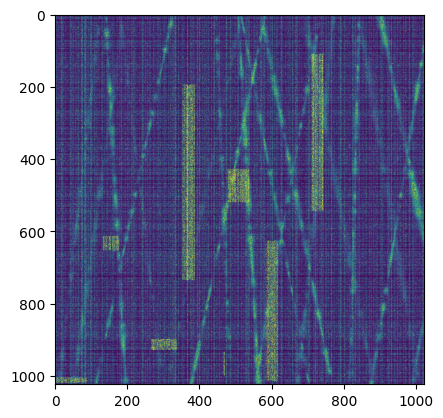

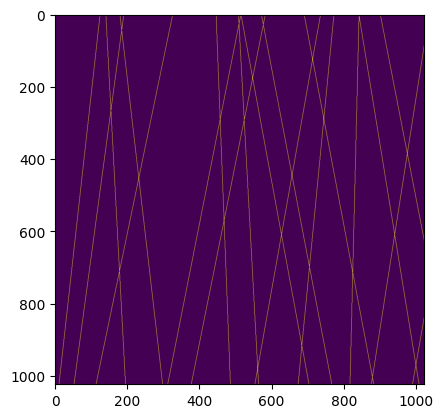

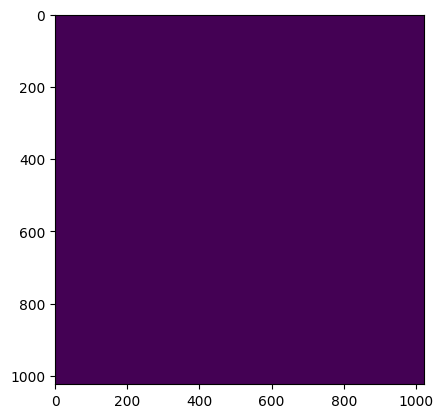

In [64]:
model.eval()

#image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
#label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)
def preproc_image(image_path, device):
  image = np.fromfile(image_path, dtype=np.single)
  image_size = int(np.sqrt(len(image)))
  image = image.reshape((image_size, image_size))

  transform = T.Compose([
      T.ToPILImage(),
      #T.Resize((256,256)),
      T.ToTensor(),
  ])

  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)
  return image



with torch.no_grad():
  for images, labels in test_loader:
    plt.imshow(images[0].squeeze())
    plt.show()
    plt.imshow(labels[0].squeeze())
    plt.show()

    images = images.to(device)
    labels = labels.to(device)

    #output_logits = model(preproc_image('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat', device))
    output_logits = model(images)
    output_logits = output_logits.cpu()
    output_logits = output_logits.squeeze(0).squeeze()
    output_logits = output_logits.numpy()
    output_logits = np.where(output_logits > 0.5, 1, 0)
    plt.imshow(output_logits)
    plt.show()

    #image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
    #image_reshaped = image.reshape((image_size, image_size))

    label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)
    labelimg_reshaped = label.reshape((image_size, image_size))
    break

